**Name:** LI XINYAN

**EID:** 55670594

**Kaggle Team Name:** Saaries98 / Saaries

# CS5489 - Assignment 2 - Sound Effects Tagging - FINAL SOLUTION
Due date: see Assignment 2 on Canvas

# Import Modules

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
import random
import datetime

from scipy import io
from scipy import stats
from pydub import AudioSegment
from IPython.display import Audio, display

from numpy import *
from sklearn import *

import os
import csv
import wave
import tqdm
import scipy
import pylab
import pickle
import librosa
import sklearn

import numpy as np
import pandas as pd
import seaborn as sns
import librosa.display
from tqdm import tqdm_notebook
import IPython.display as ipd

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split

from keras import losses, models
from keras.activations import relu, softmax
from keras.layers import Dense, Dropout, Input, Convolution2D, BatchNormalization, Activation, MaxPool2D, Flatten
from keras.callbacks import EarlyStopping

from tensorflow import optimizers
from tensorflow.keras.utils import Sequence, to_categorical

random.seed(100)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train_wav_dir = 'train_wav/'
train_wav_trim_dir = 'train_wav_trim/'
test_wav_dir = 'test_wav/'
test_wav_trim_dir = 'test_wav_trim/'

# Helper Functions

In [3]:
def showAudio(info):
    display(Audio(info['previews']['preview-lq-mp3']))

def load_pickle(fname):
    f = open(fname, 'rb')
    out = pickle.load(f)
    f.close()
    return out

In [4]:
def write_csv_kaggle_tags(fname, tagnames, Yscores):
    tmp = [['Id']]
    for t in tagnames:
        tmp[0].append(t)    
    
    for i in range(len(Yscores)):
        tmp2 = [(i+1)]
        for t in range(len(tagnames)):
            tmp2.append(Yscores[i,t])
        
        tmp.append(tmp2)
        
    f = open(fname, 'w')
    writer = csv.writer(f)
    writer.writerows(tmp)
    f.close()

In [5]:
def compute_delta_mfccs(mfccs):
    dmfccs = []
    for m in mfccs:
        tmp = m[1:] - m[0:-1]
        dm = hstack((m[0:-1], tmp))
        dmfccs.append(dm)
    return dmfccs

In [6]:
def class2tags(classes, tagnames):
    tags = []
    for n in range(classes.shape[0]):
        tmp = []
        for i in range(classes.shape[1]):
            if classes[n,i]:
                tmp.append(tagnames[i])
        tags.append(" ".join(tmp))
    return tags

def tags2class(tags, tagnames):
    b = zeros(shape=(len(tags), len(tagnames)))
    for i,t in enumerate(tags):
        for j,n in enumerate(tagnames):
            if n in t:
                b[i,j] = 1
    return b

In [7]:
def bow_transform(model, mfccs):
    numwords = model.cluster_centers_.shape[0]
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows

In [8]:
# This function pad the input data by copying itself, using MFCC featues
def prepare_audio(fnames, config, data_dir):
    max_len = config.audio_length
    print('Audio len:', max_len)
    
    X = np.empty(shape=(len(fnames), config.n_mfcc, max_len,  1))
    
    for i, fname in tqdm_notebook(enumerate(fnames), total=len(fnames)):
        file_path = os.path.join(data_dir, fname)
        
        a, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")
        d = librosa.feature.mfcc(a, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        
        # duration
        if len(d[0]) > max_len:
            max_offset = len(d[0]) - max_len
            offset = np.random.randint(max_offset)
            d = d[:, offset: (max_len + offset)]
        else:
            if len(d[0]) < max_len:
                pad_len = max_len - len(d[0])
                times = int(pad_len / len(d[0])) + 2
                d = np.tile(d, times)
            d = d[:, : max_len]

        d = np.expand_dims(d, axis=-1)
    
        X[i,] = d
    return X

In [9]:
class Config(object):
    def __init__(self,
                 sampling_rate=44100, audio_duration=10, n_classes=22, 
                 learning_rate=0.001, max_epochs=20, n_mfcc=13):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.n_mfcc = n_mfcc
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.audio_length =  1 + int(np.floor(self.sampling_rate * self.audio_duration / 512))
        self.dim = (self.n_mfcc, self.audio_length, 1)

In [10]:
# plot an ROC curve using class labels and class scores
def plot_roc(tagnames, Yclasses, Yscores):
    fprall = []
    tprall = []
    aucall = []
    for i in range(len(tagnames)):
        fpr, tpr, thresholds = metrics.roc_curve(Yclasses[:,i], Yscores[:,i])
        plt.plot(fpr, tpr, lw=0.5, alpha=0.5)
        auc = metrics.auc(fpr, tpr)
        fprall.append(fpr)
        tprall.append(tpr)
        aucall.append(auc)

    all_fpr = unique(concatenate(fprall))
    mean_tpr = zeros_like(all_fpr)
    for i in range(len(tagnames)):
        mean_tpr += interp(all_fpr, fprall[i], tprall[i])

    mean_tpr /= len(tagnames)
    auc = metrics.auc(all_fpr, mean_tpr)
    mc_auc = np.mean(aucall)

    plt.plot(all_fpr, mean_tpr, 'k-', lw=2)
    plt.title('MCAUC={:.4f}, AUC={:.4f}'.format(mc_auc, auc))

    plt.grid(True)

In [11]:
# This function plot the PCA curve
def plot_exp_ratio(ratio, title):
    explain_fig = plt.figure()
    idx = where(ratio > 0.95)[0][0]
    print("95% ratio when components are {}".format(idx))
    plt.title(title)
    plt.plot(ratio)

# Load Data

In [12]:
train_tags  = load_pickle('sound-data/train_tags.pickle3')
train_mfccs = load_pickle('sound-data/train_mfccs.pickle3')
train_info  = load_pickle('sound-data/train_info.pickle3')

test_mfccs = load_pickle('sound-data/test_mfccs.pickle3')
test_info  = load_pickle('sound-data/test_info.pickle3')

In [13]:
train_dmfccs = compute_delta_mfccs(train_mfccs)
test_dmfccs  = compute_delta_mfccs(test_mfccs)

In [14]:
tagnames, tagnames_counts = unique(concatenate(train_tags), return_counts=True)
for a,b in zip(tagnames, tagnames_counts):
    print("{}: {}".format(a, b))

acoust: 100
analog: 100
bass: 160
beat: 128
drum: 371
effect: 141
electron: 194
field: 110
glitch: 110
guitar: 130
hit: 110
loop: 237
machin: 100
metal: 117
nois: 199
percuss: 285
record: 192
space: 125
synth: 220
synthes: 136
vocal: 120
voic: 167


In [15]:
train_classes = tags2class(train_tags, tagnames)
sum(train_classes,axis=0)

array([100., 100., 160., 128., 371., 141., 194., 110., 110., 130., 110.,
       237., 100., 117., 199., 285., 192., 125., 220., 136., 120., 167.])

In [16]:
all_dmfccs = vstack(train_dmfccs)
print(all_dmfccs.shape)

(391816, 26)


In [17]:
km = cluster.KMeans(n_clusters=500, random_state=4487)
km.fit(all_dmfccs[0::10])

train_bow = bow_transform(km, train_dmfccs)
test_bow  = bow_transform(km, test_dmfccs)

In [18]:
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)

In [19]:
pca_model = decomposition.TruncatedSVD(n_components=499)
pca_model.fit(train_Xtf)

TruncatedSVD(n_components=499)

95% ratio when components are 285


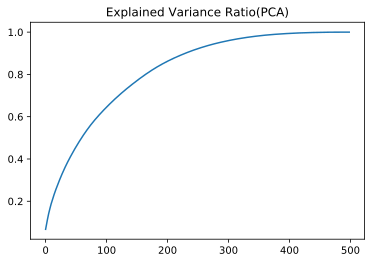

In [20]:
plot_exp_ratio(cumsum(pca_model.explained_variance_ratio_), 
               "Explained Variance Ratio(PCA)")

In [21]:
pca_500To285 = decomposition.TruncatedSVD(n_components=285)
pca_500To285.fit(train_Xtf)

train_Xtf = pca_500To285.transform(train_Xtf)
test_Xtf = pca_500To285.transform(test_Xtf)

# Training

In [22]:
from sklearn.neural_network import MLPClassifier

tagmodels = {}
for i,t in enumerate(tagnames):
    print('training {} - {}'.format(i, t))
    myY = train_classes[:,i].ravel()
    parameters = {'hidden_layer_sizes': np.array([(100, 10), (100,), (50, 50)]),
                  'learning_rate': np.array(['constant', 'invscaling', 'adaptive'])}
    
    mlp = GridSearchCV(MLPClassifier(), parameters, cv=5, n_jobs=-1, verbose=False)
    mlp.fit(train_Xtf, myY)
    tagmodels[t] = mlp.best_estimator_

training 0 - acoust


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 1 - analog


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 2 - bass


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 3 - beat
training 4 - drum


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 5 - effect


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 6 - electron


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 7 - field
training 8 - glitch


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 9 - guitar


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 10 - hit


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 11 - loop


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 12 - machin
training 13 - metal


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 14 - nois


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 15 - percuss
training 16 - record


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 17 - space


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 18 - synth


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 19 - synthes


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 20 - vocal
training 21 - voic


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


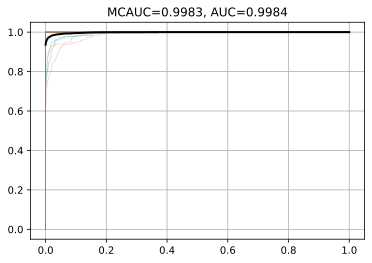

In [23]:
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].predict_proba(train_Xtf)[:, 1]
    train_predscore[:,i] = tmp

plot_roc(tagnames, train_classes, train_predscore)

In [24]:
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].predict_proba(test_Xtf)[:, 1]
    test_predscore[:,i] = tmp

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


In [25]:
write_csv_kaggle_tags("MLP_bow_pca_final.csv", tagnames, test_predscore)